In [70]:
%matplotlib inline
import wikipediaapi
from scipy import linalg
import networkx as nx
# Two fundamental packages for doing data manipulation
import numpy as np                   # http://www.numpy.org/
import pandas as pd                  # http://pandas.pydata.org/

#  for plotting data
import matplotlib.pyplot as plt      # http://matplotlib.org/

# Package to save/load Python structures in the "Pickle" format
import pickle

# For using Regular Expression string searches
import re
import requests 


# 1. Crawling web pages
Consider the wikipedia page on 'World Wide Web'. The task is to crawl the webpages following a breadth-first search (BFS). You need to set the pllimit to 50.
You should continue until you have reached a (unique) page count of 500 or have exhausted the queue. For each page you need to obtain the extracts and save them (with page title as name) as separate documents. You need to store these pages in a folder titled 'Docs' (please ensure that the name of the folder is 'Docs'). Also create a list with name 'BFS_page_list' containing the titles of the pages in the BFS order.  

500
['World Wide Web', 'ARPANET', 'ASCII', 'Academic journal', 'Access control', 'Accessibility', 'Active Server Pages', 'Ajax (programming)', 'Al Gore and information technology', 'Alexander Graham Bell', 'Alexander Stepanovich Popov', 'Alfred Vail', 'Algorithm', 'Alternative media', 'Amazon (company)', 'Anonymous blog', 'Antonio Meucci', 'Application-Level Profile Semantics (ALPS)', 'Application layer', 'Application server', 'Apress', 'Art blog', 'As We May Think', 'Assistive technology', 'Astroturfing', 'Asynchronous IO', 'Atom (Web standard)', 'Atom (standard)', 'Attack (computing)', 'Audio signal', 'BITNET', 'Beacon', 'Biblioteca Nacional de España', 'Bibliothèque nationale de France', 'BitTorrent', 'Blawg', 'Blog', 'Blog carnival', 'Blog fiction', 'Blogosphere', 'Bracket', 'Brendan Eich', 'Broadcatching', 'Brown University', 'Browser cache', 'Browser engine', 'Building block', 'CERN', 'CNAME record', 'CYCLADES', 'Cable protection system', 'Cable television', 'CamelCase', 'Camille

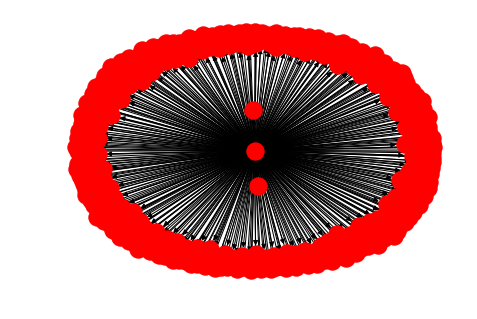

In [71]:
def filtered_str(str_):
    if '/' or '"' in str_:
        str_ = str_.replace('/', '')
        str_ = str_.replace('"', '')
    return str_ 

G=nx.DiGraph()
G.clear()
count_unique = 0
BFS_page_list = []
G.add_node('World Wide Web')
BFS_page_list.append('World Wide Web')

api_url = 'https://en.wikipedia.org/w/api.php'
param_www={'action': 'query',
            'titles': 'World Wide Web',
            'prop': 'links',
            'pllimit':'500',
            'rvlimit': 'max',
            'continue':'',
            'format': 'json'}

result = requests.get(url = api_url, params = param_www, timeout=30)
www_json = result.json()
links = www_json['query']['pages']['33139']['links']
for link in links:
    G.add_edge('World Wide Web', filtered_str(link['title']))
    BFS_page_list.append(filtered_str(link['title']))

count_unique = int(param_www['pllimit'])

for edge in list(G.edges()):
    if count_unique == 500: 
        break        
    param_new={'action': 'query',
            'titles': edge[1],
            'prop': 'links',
            'pllimit':'500',
            'rvlimit': 'max',
            'continue':'',
            'format': 'json'}
    result = requests.get(url = api_url, params = param_new, timeout=30)
    new_json = result.json()
    links = new_json['query']['pages'][list(new_json['query']['pages'].keys())[0]]['links']
    for link in links:
        if link['title'] not in G.nodes():
            if count_unique!=500: 
                count_unique +=1
            else:
                break
        G.add_edge(edge[1], filtered_str(link['title']))
        BFS_page_list.append(filtered_str(link['title']))

nx.draw(G, size = 3, pos=nx.spring_layout(G))        #with_labels=True,
print(count_unique)
print(BFS_page_list)

In [72]:
wiki_wiki = wikipediaapi.Wikipedia('en')

for page in BFS_page_list:
    page_py = wiki_wiki.page(page)
    ps = page_py.summary
    filename = r"C:\Users\Kravchis\Desktop\web-mining\Docs\%s" %page + ".txt" #path for DOCS 
    with open(filename, "wb") as f:
        f.write(ps.encode("utf-8"))
 

# 2. Preprocessing 
Remove the stopwords from the documents obtained in the previous step and also perform stemming. You should use the stopword list provided by Python-nltk library. You are required to store the processed documents in a new folder named 'ProcessedDocs'. Name of the pages should be same as the title.

In [73]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

def remove_stopwords(exintro):
    stop_words = set(stopwords.words('english')) 
    words = exintro.split(' ')
    article = ''
    for w in words:
        if w not in stop_words:
            article += w + ' '
    return article.strip() 

def remove_punc(exintro):
    words = tokenizer.tokenize(exintro)
    article = ''
    for w in words:
        if w not in stop_words:
            article += w + ' '
    return article.strip()   

def stemming(exintro):
    ps = PorterStemmer()
    words = exintro.split(' ')
    article = ''
    for w in words:
        w_ = ps.stem(w)
        article += w_+' '
    return article.strip()

for page in BFS_page_list:
    filename = r"C:\Users\Kravchis\Desktop\web-mining\Docs\%s" %page + ".txt" #path for DOCS 
    with open(filename, "r", encoding="UTF-8") as f: 
        contents = f.read()
        
    processed = remove_punc(stemming(remove_stopwords(contents))) 
    filename_processed = r"C:\Users\Kravchis\Desktop\web-mining\ProcessedDocs\%s" %page + ".txt"#path for ProcessedDOCS
    
    with open(filename_processed, "wb") as f: 
        f.write(processed.encode("utf-8"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kravchis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 3. Calculating relevance score of documents
Consider a query 'hypertext web internet' and calculate the similarity scores for all the documents related to the query using latent semantic indexing with SVD and 4-concept space. (Use cosine similarity as the similarity metric). Store the similarity scores in a dictionary named 'LSIscores' with the names of the pages as keys and similarities as values.

In [74]:
import textmining
import scipy
import operator
from scipy import spatial

def A(BFS_page_list):
    tdm = textmining.TermDocumentMatrix()    
    for page in BFS_page_list:
        filename_processed = r"C:\Users\Kravchis\Desktop\web-mining\ProcessedDocs\%s" %page + ".txt"
        with open(filename_processed, "r", encoding="UTF-8") as f: 
            contents = f.read()
        tdm.add_doc(contents)
    A = []
    for row in tdm.rows(cutoff=1):
        A.append(row)
    return np.asarray(A)

A_m = A(BFS_page_list)
A_t = A_m.transpose()[:,1:]
U, s, Vh = scipy.linalg.svd(A_t, full_matrices=True, compute_uv=True)
k = 4                 
q = np.array([])
for w in A_m[0]:
    if w in ['hypertext', 'web', 'internet']:
        q = np.append(q, 1)
    else:
        q = np.append(q, 0)

qk = np.dot(np.dot(q, U[:,:k]), np.linalg.inv(np.diag(s[:k])))
LSIscores = {}
for _ in range(len(BFS_page_list)):
    vk = np.dot(np.dot(list(map(float, A_t[:, _])), U[:,:k]), np.linalg.inv(np.diag(s[:k])))
    LSIscores[BFS_page_list[_]] = 1 - spatial.distance.cosine(vk,qk)

LSIscores_s = sorted(LSIscores.items(), key=operator.itemgetter(1), reverse = True)
print(LSIscores_s)

[('Safari (web browser)', 0.9939487210042061), ('Livemark', 0.990100660491825), ('Firefox', 0.9772041347076074), ('Outlook.com', 0.9726288949902714), ('Mobile Web', 0.9645770747673006), ('Mosaic (web browser)', 0.9616466837505574), ('HTTP', 0.9295920088912896), ('Hypertext Transfer Protocol', 0.9295920088912896), ('Gopher (protocol)', 0.9263663475057216), ('Google Chrome', 0.9224922780791575), ('History of the World Wide Web', 0.9212907024147569), ('Marc Andreessen', 0.9019976645086715), ('Netscape', 0.9019781931980472), ('Finjan', 0.8862865476202767), ('Pronunciation of www', 0.8759520512601833), ('World Wide Web', 0.8693736719248705), ('Application server', 0.8612320032352127), ('Deep web', 0.8459836974918016), ('Active Server Pages', 0.8399786089588572), ('Browser engine', 0.8357077533439875), ('Client–server architecture', 0.8158864352863993), ('ENQUIRE', 0.8114897483503825), ('Document Object Model', 0.8068610453844095), ('FOAF (ontology)', 0.7953469877789824), ('Home page', 0.794

# 4. Creating network of webpages
Create a network of web pages crawled in the first step. The nodes are web pages and a link appears between two pages a and b if a has a link to b in its page. Note that you should only consider the links to web pages that you have crawled and not all the links. Store the adjacency matrix in a variable named 'adjacency\_mat' with the nodes ordered alphabetically. Also store the number of nodes and edges of the obtained graph in variables 'nodes\_' and 'edges\_'

In [75]:
#The creation of the graph was implemented in assignment 1 as we found using a graph as a data structure was 
#appropriate for that task.
#Also the implementation of the graph in plart one facilitates testing much better.


adjacency_mat = nx.to_numpy_matrix(G, sorted(G.nodes()))
nodes_ = G.number_of_nodes()
edges_ = G.number_of_edges()

adjacency_mat

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 0.]])

# 5. Dynamic PageRank
Consider a random walk setting where the transistion matrix changes over time. At any point of time the probability of a random surfer to jump to a linked page is proportional to the number of previous visits. To start with all the pages are equally likely to be chosen but as the walk continues and the nodes are visited the transition probability changes as proportional to number of previous visits. For example let a page 'a' is linked to pages 'b', 'c' and 'd'. The random surfer currently resides at 'a' and the pages 'b', 'c' and 'd' have already been visited 5, 3 and 2 times respectively. The transition probability would be 0.5, 0.3 and 0.2 respectively. As a new node is viited the probabilities change. The random surfer continues to surf with probability 0.95. Generate 500 random walks and rank the nodes based on the frequency of visit. The random walk should be performed on the network obtained in the previous step.

The function should be of the form def dynamicPageRank(graph=G, num_walks=500, telprob=0.8). You should store the results in a dictionary named 'PageRankscores' with keys as page names and number of visits as values

In [76]:


#Implementation for graph that is not strongly connected fixed through rank one update (stochasticity adjustment) 
#conforming with original pageRank implementation. We did not take nodes out even if they were deadends.
#Motivation: each page should get a rank even though it is a rank sink or spider trap.

#Walks from dangling nodes are considered random walks as the user essentially has a hyperlink to all nodes possible
#On the other hand teleports are not considered random walks as they do not continue the walk. Both situations(teleportation and dangling nodes) are counted 
#as visits. 
#Motivation: If nodes that are accessed from a dangling node walk or teleportation would not be counted then some nodes would never get a rank
#and never be selected when random walking. 

#Iterative pagerank process was implemented with the dimensions reversed as to conform with the classic pagerank implementation
#meaning rank is a row vector(instead of column) and transition matrix is transposed in opposition to process presented in the lecture



def dynamicPageRank(graph=G, num_walks=500, telprob=0.95):
    adj_matrix = np.asarray(nx.to_numpy_matrix(graph, sorted(graph.nodes)))
    trans_mat = np.asarray(nx.google_matrix(graph,nodelist = sorted(graph.nodes), alpha = 1))
    n = adj_matrix.shape[0]
    e = np.array([1]*n)
    
    visited = np.array([0]*n)             #visit frequency vector. needed for computing probabilities at runtime
    initialized = np.array([0]*n)         #vector needed for not messing with the first iteration where probabilities are uniform
    currNode = np.random.randint(n)
    walkCount = 0
    
    rank = np.array([1.0/n]*n)
    
    while walkCount != 500:
        
        initialized[currNode] = 1
        
        rank = telprob * rank.dot(trans_mat) + (1-telprob)/n * e
        
        if (np.random.choice(['walk', 'teleport'], p = [0.95, 0.05]) == 'teleport'):
            currNode = np.random.randint(n)
        else:
            walkCount += 1
            currNode = np.random.choice(n, p = trans_mat[currNode,:].tolist())
        
        trans_mat = update(adj_matrix, trans_mat,initialized, visited, currNode)
        
    return rank
    #check if index in addj matrix corresponds to names

def update(matrix, former_trans_mat,initialized, visited, node):
    n = matrix.shape[0]
    visited[node] += 1
    trans_matrix = np.zeros((n,n))
    
    for i in range(n):

        visitedOutlinks = np.dot(matrix[i,:], visited)
        
        if visitedOutlinks and initialized[i] :
            for j in range(n):
                if matrix[i,j] == 1 :
                    trans_matrix[i,j] = visited[j] / visitedOutlinks
        else :
            trans_matrix[i,:] = former_trans_mat[i,:]
    
    
    
    return trans_matrix
    
PageRankscores = dict()
rank = dynamicPageRank()
for r,key in enumerate(sorted(G.nodes)):
    PageRankscores[key] = rank[r]

print(PageRankscores)

{'ARPANET': 0.0019958560083108874, 'ASCII': 0.0019958560083108874, 'Academic journal': 0.001992230301822896, 'Access control': 0.0019958560083108874, 'Accessibility': 0.0019958560083108874, 'Active Server Pages': 0.00199948171479888, 'Ajax (programming)': 0.00199948171479888, 'Al Gore and information technology': 0.0019958560083108874, 'Alexander Graham Bell': 0.0019958560083108874, 'Alexander Stepanovich Popov': 0.0019958560083108874, 'Alfred Vail': 0.0019958560083108874, 'Algorithm': 0.0020031074212868718, 'Alternative media': 0.001992230301822896, 'Amazon (company)': 0.0020067331277748633, 'Anonymous blog': 0.0020031074212868718, 'Antonio Meucci': 0.001992230301822896, 'Application layer': 0.00199948171479888, 'Application server': 0.0019958560083108874, 'Application-Level Profile Semantics (ALPS)': 0.001992230301822896, 'Apress': 0.00199948171479888, 'Art blog': 0.00199948171479888, 'As We May Think': 0.00199948171479888, 'Assistive technology': 0.00199948171479888, 'Astroturfing':

# 6. Combined ranking
Rank the documents based on the relevance score obtained in step 3 as well as the frequency of visits in the previous step (dynamic PageRank). Combine the rankings using Borda Ranking and obtain the top 10 most relevant web pages (documents). You should print the title of the web pages. 

In [77]:
bordaScores = dict()
n = nodes_

i = n
for key,value in sorted(PageRankscores.items(), key = lambda y: y[1], reverse = True ):
    bordaScores[key] = i
    i -= 1

    
i = n

for key,value in sorted(LSIscores.items(), key = lambda y: y[1], reverse = True ):
    bordaScores[key] += i
    i -= 1


print([i[0] for i in sorted(bordaScores.items(), key = lambda y: y[1],reverse = True)[:10]])

['Outlook.com', 'History of the World Wide Web', 'Dynamic content', 'Cascading Style Sheets', 'Active Server Pages', 'Email', 'Hypertext', 'Client–server architecture', 'Document Object Model', 'ENQUIRE']
